In [1]:
# Imports
import numpy as np
import imageio
import matplotlib.pyplot as plt
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def euclidean_distance(n):
    distance = np.linspace(-(n - 1) / 2, (n - 1) / 2, n).astype(int)
    ed = np.zeros([n,n])
    central_point = int((n-1)/2)
    for x in distance:
        for y in distance:
            ed[x+central_point,y+central_point] = np.sqrt((np.power(x, 2) + np.power(y, 2)))
            
    return ed

In [3]:
def gaussian_kernel(x, sigma):
    a = 1.0/(2*np.pi*np.square(sigma))
    b = np.exp(-np.square(x)/(2*np.square(sigma)))
    return a * b

In [4]:
def spatial_component(n, sigma):
    ed = euclidean_distance(n)
    gs = np.zeros([n,n]) # Gaussian Spatial Componente
    for x in range(n):
        for y in range(n):
            gs[x, y] = gaussian_kernel(ed[x,y], sigma)

    return gs

In [5]:
def window(sub_i, gs, a, b):
    
    N,M = sub_i.shape
    Wp = 0
    pixel_value = 0
    
    # Gaussian Range
    gr = np.zeros([n,n]) # , dtype=np.uint8

    # for every pixel
    for i in range(N):
        for j in range(M):
            # diff: I_i - I_(x,y)
            diff = sub_i[i,j] - sub_i[a,b]
            # computes g at (x,y)
            gr[i,j] = gaussian_kernel(diff, sigma_r)
            w = gr[i,j] * gs[i,j]
            Wp += w
            pixel_value += (sub_i[i,j] * w)

    pixel_value = pixel_value / Wp
    return pixel_value

In [6]:
def bilateral_filter(n):
    N,M = input_img.shape
    a = int((n-1)/2) # Center Row
    b = int((n-1)/2) # Center Col
    
    output_img = np.zeros(input_img.shape, dtype=np.uint8)
    
    gs = spatial_component(n, sigma_s)
    
    # for every pixel
    for x in range(a,N-a):
        for y in range(b,M-b):
            # gets subimage
            sub_i = input_img[ x-a : x+a+1 , y-b:y+b+1 ]
            output_img[x,y] = window(sub_i, gs, a, b).astype(np.uint8)
    
    return output_img



In [7]:
#sub_i = np.array([[5, 39, 45], [88, 12, 100], [145, 159, 136]])
def window_laplacian(sub_i, k):
    kernel_1 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    kernel_2 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    kernel = kernel_1 if k == 1 else kernel_2
    return np.sum(np.multiply(sub_i, kernel))

In [8]:
def laplacian_filter():
    N,M = input_img.shape
    n = 3 # size of window
    a = int((n-1)/2)

    # new image to store filtered pixels
    output_img = np.zeros(input_img.shape)

    # for every pixel
    for x in range(a,N-a):
        for y in range(a,M-a):
            # gets subimage
            sub_i = input_img[ x-a : x+a+1 , y-a:y+a+1 ]
            output_img[x,y] = window_laplacian(sub_i, k)

    # Normalize the image
    imax = np.max(output_img)
    imin = np.min(output_img)
    output_img = ((output_img - imin) * 255) / imax
    
    # Add c weight
    output_img = (c * output_img) + input_img
    
    # Normalize
    imax = np.max(output_img)
    imin = np.min(output_img)
    output_img = ((output_img - imin) * 255) / imax

    return output_img.astype(np.uint8)

In [9]:
def vignette_filter(std_row, std_col):
    # Get Rows size and Column Size
    rows,cols = input_img.shape

    # Get the center of the rows and columns
    center_row = int(round((rows/2)-1))
    center_col = int(round((cols/2)-1))

    # Get positon values: -2, -1, 0, 1, 2
    distance_row = np.linspace(-(rows - 1) / 2, (rows - 1) / 2, rows).astype(int)
    distance_col = np.linspace(-(cols - 1) / 2, (cols - 1) / 2, cols).astype(int)

    # Gaussian Kernel Row
    k_row = []
    for i in range(rows):
        #std_row = np.std(input_img[i])
        k_row.append(gaussian_kernel(distance_row[i], std_row))

    # Gaussian Kernel Col
    k_col = []
    for i in range(cols):
        #std_col = np.std(input_img[:][i])
        k_col.append(gaussian_kernel(distance_col[i], std_col))

    # Apply filter in the input image    
    k_col = np.array(k_col).reshape(cols,1)
    k_row = np.array(k_row).reshape(rows,1)
    w = k_col.T * k_row
    output_img = w * input_img

    # Normalize the output_img
    imax = np.max(output_img)
    imin = np.min(output_img)
    output_img = ((output_img - imin) * 255) / imax

    return output_img


In [10]:
# Inputs
def inputs():
    print('Filename: ')
    filename = str(input()).rstrip()
    input_img = imageio.imread('input_and_output_imgs/' + filename)
    print()
    print('Method(1, 2 or 3): ')
    method = int(input())
    print()
    print('Save(0-No, 1-Yes): ')
    save = int(input())
    
    return input_img, method, save

In [11]:
# Compare with reference
def compare():
    accumulate = 0
    rows = input_img.shape[0]
    cols = input_img.shape[1]

    # Loop through all pixels
    for x in range(rows):
        for y in range(cols):
            accumulate += np.power(float(output_img[x,y]) - float(input_img[x,y]), 2)

    rse = np.around(np.sqrt(accumulate), decimals=4)
    print()
    print('RSE:' + str(rse))

In [24]:
# Starting the process
input_img, method, save = inputs()

# Select the transformation method
if method == 1:
    print()
    print('Size of filter n:')
    n = int(input())
    print()
    print('Parameter sigma_s:')
    sigma_s = float(input())
    print()
    print('Parameter sigma_r:')
    sigma_r = float(input())
    output_img = bilateral_filter(n)
if method == 2:
    print()
    print('Parameter c <= 1:')
    c = float(input())
    print()
    print('Parameter Kernel (1 or 2):')
    k = int(input())
    output_img = laplacian_filter()
if method == 3:
    print()
    print('Parameter row:')
    std_row = float(input())
    print()
    print('Parameter col:')
    std_col = float(input())
    output_img = vignette_filter(std_row, std_col)
    
# Compare with reference
compare()

if save == 1:
    imageio.imwrite('output_img.png',output_img)

Filename: 
flower.png

Method(1, 2 or 3): 
3

Save(0-No, 1-Yes): 
0

Parameter row:
50

Parameter col:
50

RSE:16789.2786


In [18]:
filename = str(input()).rstrip()
input_img = imageio.imread('input_and_output_imgs/' + filename)

arara.png


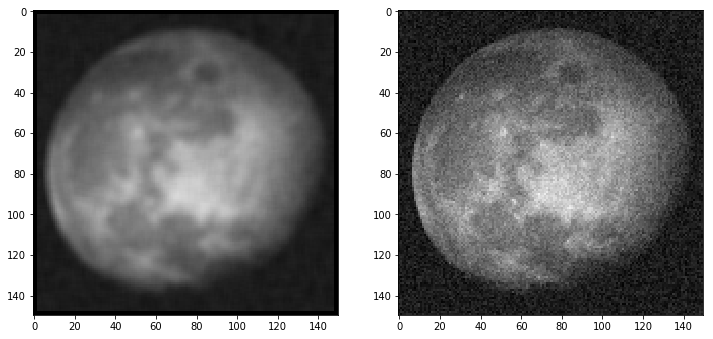

In [17]:
#
# Bilateral Filter
#
# showing images
plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(output_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(input_img, cmap="gray", vmin=0, vmax=255)

In [19]:
k = 1
c = 0.5
output_img = laplacian_filter()
print(np.min(output_img))
print(np.max(output_img))
compare()

0
224

RSE:4799.4381


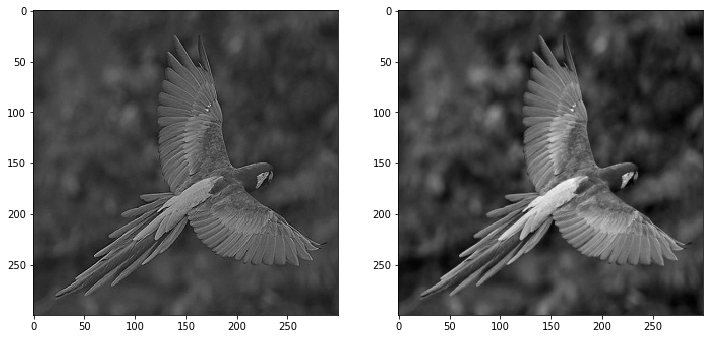

In [20]:
# showing images
plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(output_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(input_img, cmap="gray", vmin=0, vmax=255)

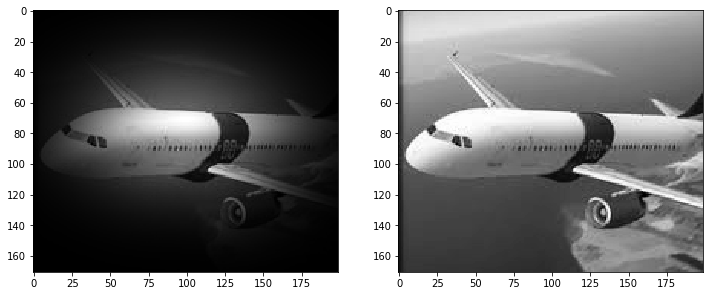

In [23]:
#
# VIGNETTE FILTER - airplane.png
#

# showing images
plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(output_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(input_img, cmap="gray", vmin=0, vmax=255)

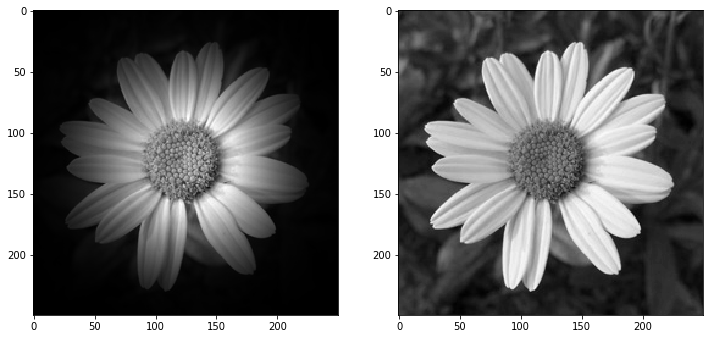

In [25]:
#
# VIGNETTE FILTER - flower.png
#

# showing images
plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(output_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(122)
plt.imshow(input_img, cmap="gray", vmin=0, vmax=255)

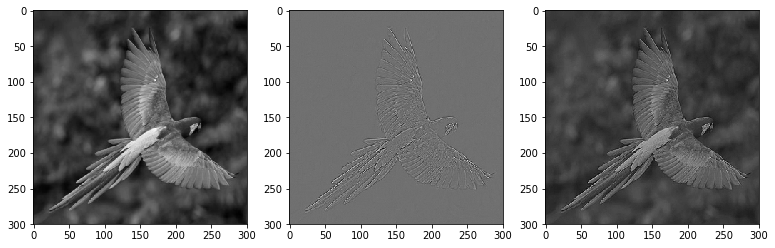

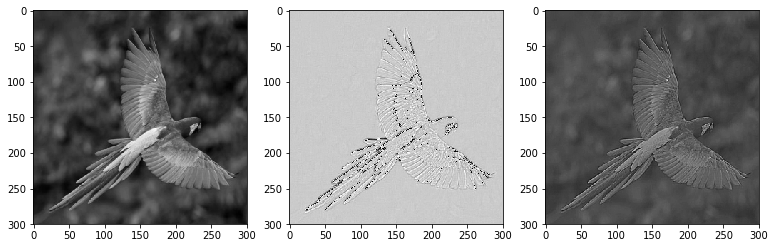

In [21]:
#
# UNSHARP MASK - LAPLACIAN FILTER
#

def laplacian_filter():
    N,M = input_img.shape
    n = 3 # size of window
    a = int((n-1)/2)

    # new image to store filtered pixels
    output_img = np.zeros(input_img.shape)

    # for every pixel
    for x in range(a,N-a):
        for y in range(a,M-a):
            # gets subimage
            sub_i = input_img[ x-a : x+a+1 , y-a:y+a+1 ]
            output_img[x,y] = window_laplacian(sub_i, k)

    # Normalize the image
    imax = np.max(output_img)
    imin = np.min(output_img)
    output_img = ((output_img - imin) * 255) / imax
    
    # Add c weight
    weigthed_img = (c * output_img)
    output_img = (c * output_img) + input_img
    
    # Normalize
    imax = np.max(output_img)
    imin = np.min(output_img)
    output_img = ((output_img - imin) * 255) / imax

    return output_img.astype(np.uint8), weigthed_img.astype(np.uint8)

# Test 1
k=1
c=0.5
output_img, weigthed_img = laplacian_filter()

# showing images
plt.figure(figsize=(13,13)) 
plt.subplot(131)
plt.imshow(input_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(weigthed_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(output_img, cmap="gray", vmin=0, vmax=255)

# Test 2
k=2
c=0.75
output_img, weigthed_img = laplacian_filter()

# showing images
plt.figure(figsize=(13,13)) 
plt.subplot(131)
plt.imshow(input_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(weigthed_img, cmap="gray", vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(output_img, cmap="gray", vmin=0, vmax=255)